In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
Cataract = '/content/drive/MyDrive/dataset/dataset/2_cataract'
Glaucoma = '/content/drive/MyDrive/dataset/dataset/2_glaucoma'
Retina_disease = '/content/drive/MyDrive/dataset/dataset/3_retina_disease'
Normal = '/content/drive/MyDrive/dataset/dataset/1_normal'

In [ ]:
import os

dir_list = [Normal, Cataract, Glaucoma, Retina_disease]
classes = ['Normal', 'Cataract','Glaucoma', 'Retina Disease']
filepaths = []
labels = []

for i,j in zip(dir_list, classes):
    filelist = os.listdir(i)
    for name in filelist:
        filepath = os.path.join(i, name)
        filepaths.append(filepath)
        labels.append(j)

print('filepaths:', len(filepaths), 'labels:', len(labels))

filepaths: 602 labels: 602


In [ ]:
file_content=pd.Series(filepaths, name='filepaths')
label_content=pd.Series(labels, name='labels')

df=pd.concat([file_content,label_content], axis=1)
df=pd.DataFrame(np.array(df).reshape(len(filepaths),2), columns = ['filepaths', 'labels'])

In [ ]:
print(df['labels'].value_counts())

Normal            301
Glaucoma          101
Cataract          100
Retina Disease    100
Name: labels, dtype: int64


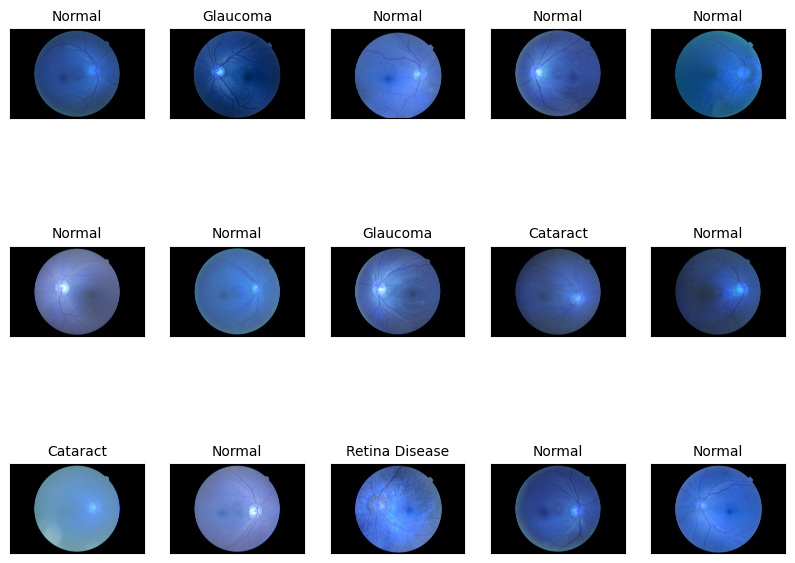

In [ ]:
import cv2

plt.figure(figsize=(10,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 10, color = "black")
    plt.xticks([])
    plt.yticks([])

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(df, test_size=0.2, random_state=42)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=42)

print(f"train set shape: {x_train.shape}")
print(f"test set shape: {x_test.shape}")
print(f"validation set shape: {x_val.shape}")

train set shape: (384, 2)
test set shape: (121, 2)
validation set shape: (97, 2)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   horizontal_flip=True,
                                   height_shift_range=0.1,
                                   fill_mode ='reflect')

validation_datagen = ImageDataGenerator(rescale = 1.0/255.0)

test_datagen = ImageDataGenerator(rescale = 1.0/255.0)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(dataframe = x_train,
                                                   x_col = 'filepaths',
                                                   y_col = 'labels',
                                                   target_size=(800,800),
                                                   class_mode='categorical',
                                                   batch_size=8)

test_generator = test_datagen.flow_from_dataframe(dataframe = x_test,
                                                  x_col = 'filepaths',
                                                  y_col = 'labels',
                                                  target_size = (800,800),
                                                  class_mode='categorical',
                                                  batch_size=8)

validation_generator = validation_datagen.flow_from_dataframe(dataframe = x_val,
                                                             x_col = 'filepaths',
                                                             y_col = 'labels',
                                                             target_size = (800,800),
                                                             class_mode='categorical',
                                                             batch_size=8)

Found 384 validated image filenames belonging to 4 classes.
Found 120 validated image filenames belonging to 4 classes.
Found 97 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
base_model = tf.keras.applications.InceptionV3(weights='imagenet',
                                                     input_shape = (800,800,3),
                                                     include_top=False,
                                                    )
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu',strides=1, input_shape=x_train.shape))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(1, 1)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(1, 1)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(4, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 23, 23, 2048)      21802784  
                                                                 
 conv2d_189 (Conv2D)         (None, 21, 21, 32)        589856    
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 21, 21, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 21, 21, 32)        0         
                                                                 
 batch_normalization_189 (B  (None, 21, 21, 32)        128       
 atchNormalization)                                              
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 21, 21, 32)       

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a learning rate schedule
def lr_schedule(epoch):
    if epoch < 10:
        return 0.000003
    elif epoch < 15:
        return 0.000001
    else:
        return 0.0000005

# Create a learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# Compile your model with the learning rate scheduler
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.000003), metrics=['accuracy'])



In [ ]:
# Train your model with more epochs and the learning rate scheduler
history = model.fit(train_generator,
                    epochs=20,  # Increase the number of epochs
                    batch_size=64,  # You can adjust the batch size
                    validation_data=validation_generator,
                    verbose=1,
                    callbacks=[lr_scheduler])

Epoch 1/20
48/48 [==============================] - 167s 3s/step - loss: 2.1303 - accuracy: 0.2656 - val_loss: 1.5432 - val_accuracy: 0.1546 - lr: 3.0000e-06
Epoch 2/20
48/48 [==============================] - 127s 3s/step - loss: 1.7924 - accuracy: 0.3724 - val_loss: 1.4716 - val_accuracy: 0.2577 - lr: 3.0000e-06
Epoch 3/20
48/48 [==============================] - 126s 3s/step - loss: 1.8586 - accuracy: 0.3620 - val_loss: 1.5129 - val_accuracy: 0.2887 - lr: 3.0000e-06
Epoch 4/20
48/48 [==============================] - 127s 3s/step - loss: 1.8720 - accuracy: 0.3724 - val_loss: 1.5786 - val_accuracy: 0.2680 - lr: 3.0000e-06
Epoch 5/20
48/48 [==============================] - 126s 3s/step - loss: 1.7737 - accuracy: 0.3906 - val_loss: 1.5609 - val_accuracy: 0.2680 - lr: 3.0000e-06
Epoch 6/20
48/48 [==============================] - 127s 3s/step - loss: 1.7116 - accuracy: 0.4271 - val_loss: 1.6472 - val_accuracy: 0.2268 - lr: 3.0000e-06
Epoch 7/20
48/48 [==============================] - 

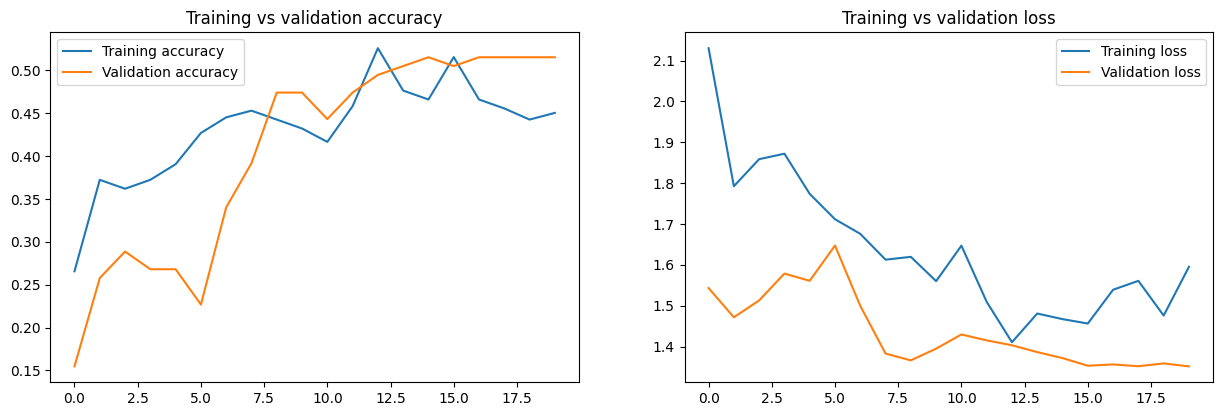

In [ ]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [ ]:
test_accuracy = model.evaluate(train_generator)[1]

48/48 [==============================] - 95s 2s/step - loss: 1.1530 - accuracy: 0.5599


In [ ]:
test_accuracy

0.5598958134651184

In [ ]:
pred = model.predict(test_generator)
pred = np.argmax(pred, axis=1)
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
y_pred = [labels[k] for k in pred]

15/15 [==============================] - 17s 1s/step


In [ ]:
print(len(x_test.labels))
print(len(y_pred))


In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, confusion_matrix

print("\n The Classification report is \n")
print(classification_report(x_test.labels, y_pred))

print("\n The Confusion Matrix is \n")
print(confusion_matrix(x_test.labels, y_pred))


 The Classification report is 



ValueError: ignored

In [ ]:
import seaborn as sns

ax = sns.heatmap(confusion_matrix(x_test.labels, y_pred), annot=True, cmap='Blues')

ax.set_title('Cataract Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Cataract','Glaucoma','Normal','Retina Disease'])
ax.yaxis.set_ticklabels(['Cataract','Glaucoma','Normal','Retina Disease'])

## Display the visualization of the Confusion Matrix.
plt.show()